## ETL (Extract Transform Load) of ATF data files using puppet

**Import all required packages and set a data path**

 - Ensure the data path points to your folder containing a bunch of ATF files. The current code assumes this folder - *labeled atf* - is in the same directory as this Jupyter notebook.

In [8]:
from puppet import ETL, Dataset
import pandas as pd
import os

data_path = "./atfs"
os.path.exists(data_path)

True

**Use puppet ETL to transform the data into the right format for further processing**

In this step we:
 - create a new `ETL` and load in all datasets in the `data_path` (./atf) folder, looking only at files with a `.atf` extension.
 - use `etl.squeeze_all` to remove all columns but *event start time*, *event end time* and *peak amp* from all datasets.
 - use `etl.column_transform` to turn *peak amp* into a positive decimal value on all datasets
 - use `etl.column_transform` to convert *event start time* from milliseconds to seconds on all datasets
 - use `etl.column_transform` to convert *event end time* from milliseconds to seconds on all datasets
 - use `etl.column_rename_all` to shorten start and end time column names on all datasets

Finally, after our transformations, we print out the resulting dataframe

In [9]:
etl = ETL().load_dir(data_path, ".atf")
etl.squeeze_all("Event Start Time (ms)", "Event End Time (ms)", "Peak Amp (pA)")
etl.column_transform_all("Peak Amp (pA)", lambda x: abs(float(x)))
etl.column_transform_all("Event Start Time (ms)", lambda x: float(x) / 1000)
etl.column_transform_all("Event End Time (ms)", lambda x: float(x) / 1000)

etl.column_rename_all("Event Start Time (ms)", "Start")
etl.column_rename_all("Event End Time (ms)", "End")

etl.datasets[0].df

4 datasets loaded from ./atfs/*.atf


,Peak Amp (pA),Start,End
0,22.30940,0.486940,0.521540
1,29.08370,1.180860,1.215460
2,28.22788,1.619640,1.654240
3,22.25071,1.961580,1.996180
4,22.00752,1.963280,1.997880
...,...,...,...
150,49.50130,117.126320,117.160922
151,46.12135,117.960820,117.995422
152,21.84872,118.038938,118.073539
153,42.88097,118.618344,118.652938


**Create IEI, Cell, and Control columns**

Below, we define three transformation functions. Each of these take in two values:
 - `row`: a row number of a dataset
 - `ds`: the dataset itself

these functions will be mapped over every row in every dataset iteratively. below we use the row id argument (`row`) and the dataset argument (`ds`) to create new columns from existing ones.

In [10]:
# for every row but the first in a dataset,
# the new column on row n should be (row[n].start_time - row[n-1].end_time)
def with_iei(row: int, ds: Dataset):
    if row == 0:
        return 0
    
    end_time = ds.get("End", row - 1)
    start_time = ds.get("Start", row)
    return start_time - end_time

# for every row in a dataset
# if the dataset file name contains the word 'control'
# the new column on row n should be True, if the filename does not contain
# 'control', the new column on row n should be False
def with_control(row: int, ds: Dataset):
    if "control" in ds.filename:
        return True
    return False

# for every row in a dataset
# the new column on row n should be the number after 'cell_' in the filename
def with_cell_number(row: int, ds: Dataset):
    cell_num = ds.filename.split("_")[1]
    return cell_num
    
# we pass our extension functions to etl here, applying them to the datasets etl holds.
etl.extend_all("IEI", with_iei)
etl.extend_all("Cell", with_cell_number)
etl.extend_all("Control", with_control)
etl.datasets[0].df

,Peak Amp (pA),Start,End,IEI,Cell,Control
0,22.30940,0.486940,0.521540,0.000000,10,True
1,29.08370,1.180860,1.215460,0.659320,10,True
2,28.22788,1.619640,1.654240,0.404180,10,True
3,22.25071,1.961580,1.996180,0.307340,10,True
4,22.00752,1.963280,1.997880,-0.032900,10,True
...,...,...,...,...,...,...
150,49.50130,117.126320,117.160922,0.125203,10,True
151,46.12135,117.960820,117.995422,0.799898,10,True
152,21.84872,118.038938,118.073539,0.043516,10,True
153,42.88097,118.618344,118.652938,0.544805,10,True


**Crush down our howevermany datasets into two large datasets: control and test**

We use `etl.crush` to define two reducer functions that apply to datasets. If a reducer called on a dataset returns `True`, the dataset will be crushed into that group.

The below example shows a crush into just two resulting datasets, but by passing more reducers to the `etl.crush` function you could crush into any number of parent datasets.

In [11]:
etl.crush({
    "control": lambda ds: "control" in ds.filename,
    "test": lambda ds: "control" not in ds.filename
})

print(f"crushed into {len(etl.datasets)} datasets")

print("Crushed 'control' group:")
print(etl.datasets[0].df)

print("Crushed 'test' group:")
print(etl.datasets[1].df)

crushed into 2 datasets
Crushed 'control' group:
     Peak Amp (pA)       Start         End       IEI Cell  Control
0         22.30940    0.486940    0.521540  0.000000   10     True
1         29.08370    1.180860    1.215460  0.659320   10     True
2         28.22788    1.619640    1.654240  0.404180   10     True
3         22.25071    1.961580    1.996180  0.307340   10     True
4         22.00752    1.963280    1.997880 -0.032900   10     True
..             ...         ...         ...       ...  ...      ...
305       49.50130  117.126320  117.160922  0.125203   12     True
306       46.12135  117.960820  117.995422  0.799898   12     True
307       21.84872  118.038938  118.073539  0.043516   12     True
308       42.88097  118.618344  118.652938  0.544805   12     True
309       28.42807  119.255477  119.290078  0.602539   12     True

[310 rows x 6 columns]
Crushed 'test' group:
     Peak Amp (pA)       Start         End       IEI Cell  Control
0         22.30940    0.486940    

**Lets use dataframes to get some stats!**

The `etl.datasets[0].df` object you've been seeing in the code is a pandas dataframe. `puppet.py` generates one for every dataset. Dataframes are like an excel spreadsheet - or interactive CSV - in python. essentially just rows and columns of organized data. Dataframes are better than Excel and CSVs though, primarily because I like them more but also because they're extremely easy to perform statistical operations on.

Below we'll find some statistical values.

In [12]:
control_group_dataframe = etl.datasets[0].df

mean_peak_amps = control_group_dataframe["Peak Amp (pA)"].mean()
stddev_peak_amps = control_group_dataframe["Peak Amp (pA)"].std()
median_peak_amps = control_group_dataframe["Peak Amp (pA)"].median()
mean_iei = control_group_dataframe["IEI"].mean()

print("Mean peak amps: ", mean_peak_amps)
print("Standard Deviation peak amps: ", stddev_peak_amps)
print("Median peak amps: ", median_peak_amps)
print("Mean IEI: ", mean_iei)

Mean peak amps:  31.258213290322576
Standard Deviation peak amps:  12.833594206693078
Median peak amps:  28.4457
Mean IEI:  0.7318718774193551


**We are gonna get graphical baby!**

Let's graph some stuff using matplotlib, great way to show visualizations in python.

Also before Tuesday July 2 I had no idea how to use matplotlib, so this is a testament to how easy it is to copy paste shit from the internet

4.376278999999997


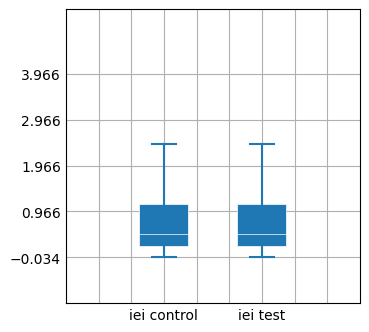

In [47]:
import matplotlib.pyplot as plt
import numpy as np

control_iei = etl.datasets[0].df["IEI"]
test_iei = etl.datasets[1].df["IEI"]
max_iei = max(control_iei.max(), test_iei.max())
min_iei = min(control_iei.min(), test_iei.min())

plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(3, 3))

VP = ax.boxplot(
    (control_iei, test_iei), 
    positions=[3, 6], 
    widths=1.5,
    showmeans=False, 
    showfliers=False,
    patch_artist=True,
    medianprops={"color": "white", "linewidth": 0.5},
    boxprops={"facecolor": "C0", "edgecolor": "white", "linewidth": 0.5},
    whiskerprops={"color": "C0", "linewidth": 1.5},
    capprops={"color": "C0", "linewidth": 1.5})

ax.set(xlim=(0, 9), ylim=(min_iei - 1, max_iei + 1), xticks=np.arange(1,9), yticks=np.arange(min_iei, max_iei))

plt.gca().set_xticklabels([ "iei control" if x == 3 else "iei test" if x == 6 else "" for x in np.arange(1, 9)])
plt.show()

**Now lets draw a line graph, not sure what we want tho will figure it out later nerd**

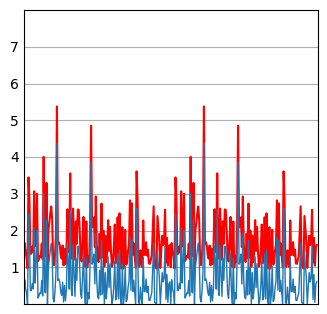

In [56]:

fig, ax = plt.subplots(figsize=(3, 3))

max_x = max(len(control_iei), len(test_iei))

ax.plot(np.arange(0, len(control_iei)), control_iei.add(1), color="red")
ax.plot(np.arange(0, len(test_iei)), test_iei, linewidth=1.0)

ax.set(xlim=(0, max_x), xticks=[],
       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()